## Gradient Boosting
Imparerete a costruire e ottimizzare i modelli con il **gradient boosting**. Questo metodo domina molte competizioni Kaggle e raggiunge risultati all'avanguardia su una varietà di set di dati.  
Per gran parte di questo corso, avete fatto previsioni con il metodo della foresta casuale, che ottiene prestazioni migliori di un singolo albero decisionale semplicemente facendo la media delle previsioni di molti alberi decisionali.

Ci riferiamo al **metodo della foresta casuale** come a un "**metodo d'insieme**". Per definizione, i **metodi ensemble** combinano le previsioni di diversi modelli (ad esempio, diversi alberi, nel caso delle foreste casuali).

Il **gradient boosting** è un metodo che procede per cicli per aggiungere iterativamente modelli a un ensemble.

Inizia inizializzando l'ensemble con un singolo modello, le cui previsioni possono essere piuttosto ingenue. (Anche se le sue previsioni sono estremamente imprecise, le aggiunte successive all'ensemble risolveranno questi errori).

Poi si avvia il ciclo:

- Utilizziamo l'**ensemble** attuale per generare previsioni per ogni osservazione del set di dati. Per fare una previsione, aggiungiamo le previsioni di tutti i modelli dell'ensemble.
- Queste previsioni vengono utilizzate per calcolare una funzione di perdita (come l'errore quadratico medio, per esempio).
- Quindi, utilizziamo la funzione di perdita per adattare un nuovo modello che verrà aggiunto all'ensemble. In particolare, si determinano i parametri del modello in modo che l'aggiunta di questo nuovo modello all'ensemble riduca la perdita. (Nota a margine: il "g**radiente**" in "**gradient boosting**" si riferisce al fatto che utilizzeremo la discesa del gradiente sulla funzione di perdita per determinare i parametri di questo nuovo modello).
- Infine, aggiungiamo il nuovo modello all'ensemble e...
- ... ripetere!
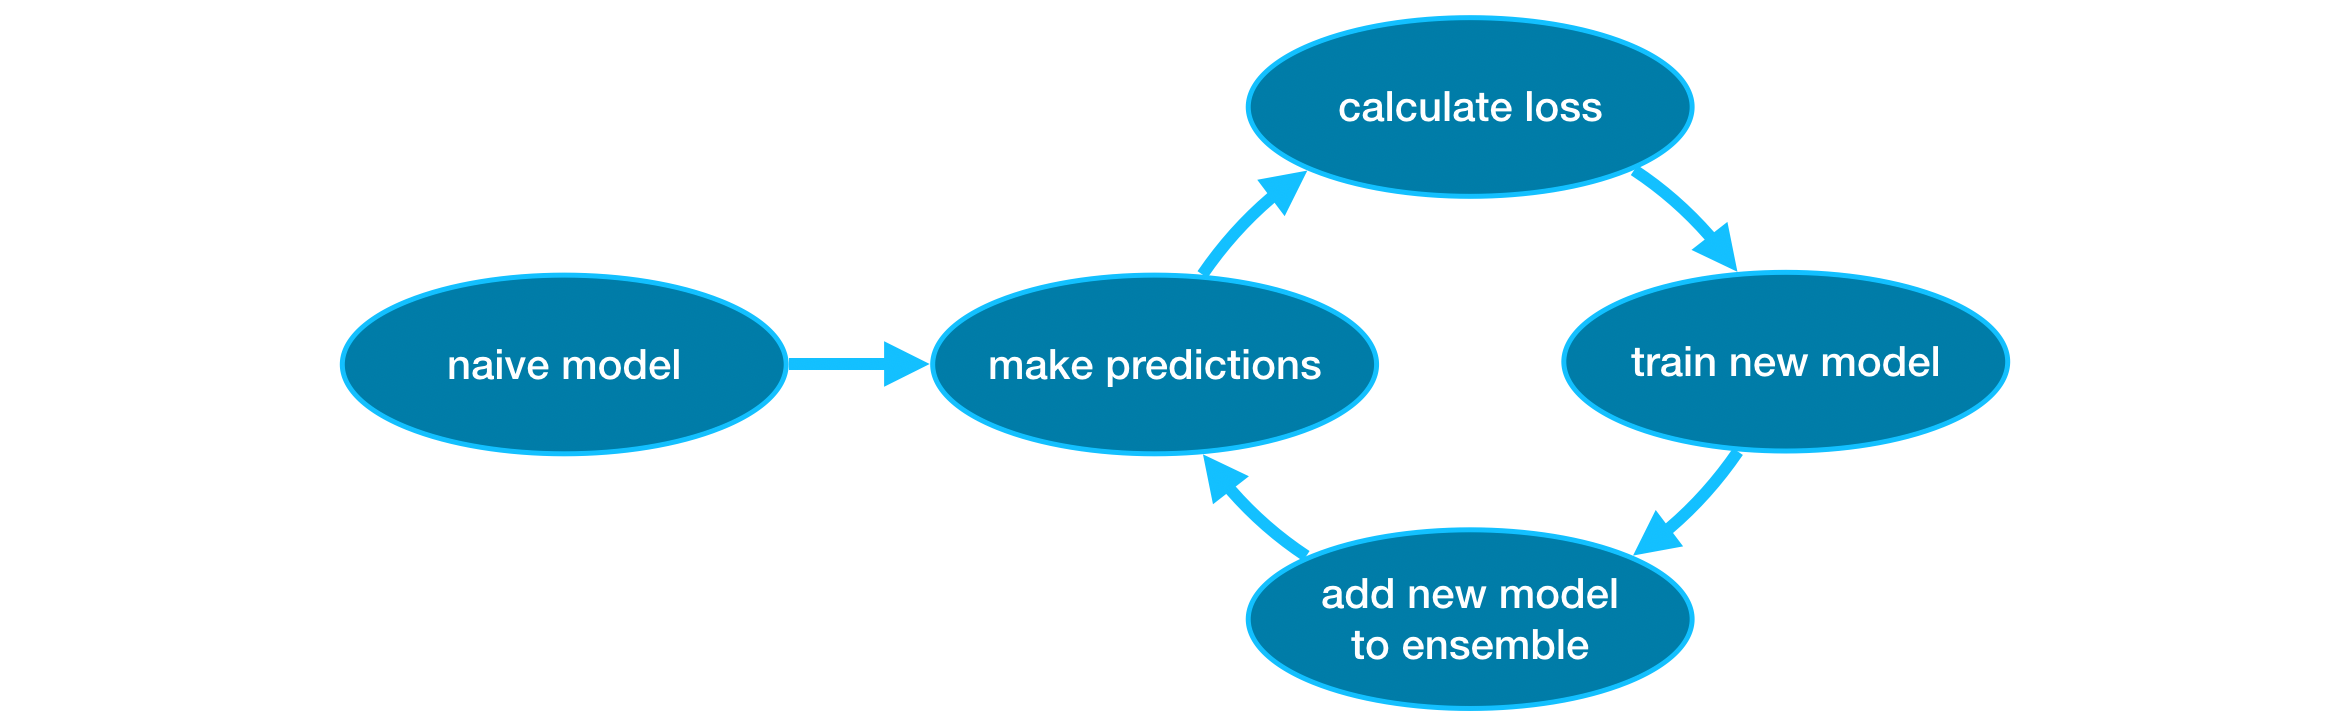

### Esempio
Si inizia caricando i dati di addestramento e di validazione in `X_train`, `X_valid`, `y_train` e `y_valid`.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In questo esempio, lavoreremo con la libreria `XGBoost`. `XGBoost` è l'acronimo di **extreme gradient boosting**, che è un'implementazione del gradient boosting con diverse caratteristiche aggiuntive incentrate sulle prestazioni e sulla velocità. (`Scikit-learn` ha un'altra versione del gradient boosting, ma `XGBoost` presenta alcuni vantaggi tecnici).

Nella prossima cella di codice, importiamo l'**API di Scikit-learn per XGBoost** (`xgboost.XGBRegressor`). Questo ci permette di costruire e adattare un modello proprio come faremmo con scikit-learn. Come si vedrà nell'output, la classe XGBRegressor ha molti parametri regolabili, che impareremo presto a conoscere!

In [2]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Facciamo anche delle previsioni e valutiamo il modello.

In [3]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 238386.038998067


## Regolazione dei parametri
`XGBoost` dispone di alcuni parametri che possono influenzare notevolmente la precisione e la velocità di addestramento. I primi parametri da comprendere sono:

**n_estimatori**  
`n_estimators` specifica quante volte eseguire il ciclo di modellazione descritto sopra. È uguale al numero di modelli che includiamo nell'**ensemble**.

- Un valore troppo basso causa un **underfitting**, che porta a previsioni imprecise sia sui dati di addestramento che su quelli di test.
- Un valore troppo alto causa un **overfitting**, che provoca previsioni accurate sui dati di training, ma imprecise sui dati di test (che sono quelli che ci interessano).
I valori tipici vanno da 100 a 1000, anche se questo dipende molto dal parametro learning_rate, discusso più avanti.

Ecco il codice per impostare il numero di modelli nell'ensemble:

In [4]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

**early_stopping_rounds**  
`early_stopping_rounds` offre un modo per trovare automaticamente il valore ideale per `n_estimatori`. L'arresto anticipato fa sì che il modello smetta di iterare quando il punteggio di convalida smette di migliorare, anche se non si è arrivati all'arresto definitivo di `n_estimatori`. È opportuno impostare un valore elevato per n_estimatori e poi usare `early_stopping_rounds` per trovare il momento ottimale per interrompere l'iterazione.

Poiché il caso a volte causa un singolo ciclo in cui i punteggi di convalida non migliorano, è necessario specificare un numero di cicli di deterioramento diretto da consentire prima di fermarsi. Impostare `early_stopping_rounds=5` è una scelta ragionevole. In questo caso, ci si ferma dopo 5 cicli di deterioramento dei punteggi di validazione.

Quando si usa `early_stopping_rounds`, occorre anche mettere da parte alcuni dati per calcolare i punteggi di convalida, impostando il parametro `eval_set`.

Possiamo modificare l'esempio precedente per includere l'arresto anticipato:

In [5]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

E:\Users\Alessio\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Se in seguito si vuole adattare un modello a tutti i dati, impostare `n_estimatori` al valore che si è rivelato ottimale quando è stato eseguito con l'arresto anticipato.

**learning_rate**  
Invece di ottenere le previsioni sommando semplicemente le previsioni di ogni modello componente, possiamo moltiplicare le previsioni di ogni modello per un piccolo numero (noto come tasso di apprendimento) prima di sommarle.

Ciò significa che ogni albero aggiunto all'ensemble ci aiuta meno. Quindi, possiamo impostare un valore più alto per `n_estimatori` senza andare in overfitting. Se si utilizza l'arresto anticipato, il numero appropriato di alberi verrà determinato automaticamente.

In generale, un tasso di apprendimento ridotto e un numero elevato di stimatori produrranno modelli XGBoost più accurati, anche se il modello impiegherà più tempo ad addestrarsi, poiché esegue più iterazioni attraverso il ciclo. Per impostazione predefinita, XGBoost imposta `learning_rate=0,1`.

Modificando l'esempio precedente per cambiare il tasso di apprendimento si ottiene il seguente codice:

In [6]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

**n_jobs**  
Su insiemi di dati più grandi, dove il tempo di esecuzione è importante, è possibile utilizzare il parallelismo per costruire i modelli più velocemente. Di solito si imposta il parametro `n_jobs` uguale al numero di core della macchina. Su insiemi di dati più piccoli, questo non è utile.

Il modello risultante non sarà migliore, quindi la **micro-ottimizzazione** per il tempo di adattamento non è altro che una distrazione. Tuttavia, è utile in insiemi di dati di grandi dimensioni, dove altrimenti si passerebbe molto tempo in attesa durante il comando di adattamento.

Ecco l'esempio modificato:

In [7]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

`XGBoost` è una libreria software leader per lavorare con dati tabellari standard (il tipo di dati che si memorizzano nei **DataFrames di Pandas**, rispetto a tipi di dati più esotici come immagini e video). Con un'attenta regolazione dei parametri, è possibile addestrare modelli molto accurati.

## Esercizi
In questo esercizio si utilizzeranno le nuove conoscenze per addestrare un modello con il **gradient boosting**.

Le domande che seguono vi forniranno un feedback sul vostro lavoro. Eseguite la seguente cella per impostare il sistema di feedback.

Eseguire la cella di codice successiva senza modifiche per caricare gli insiemi di addestramento e validazione in `X_train`, `X_valid`, `y_train` e `y_valid`.  L'insieme di test viene caricato in `X_test`.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/train.csv', index_col='Id')
X_test_full = pd.read_csv('D:/Users/Alessio/OneDrive/Python/Kaggle/Intermediate Machine Learning/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

### Domanda 1
**Costruire il modello**  
In questa fase, si costruirà e addestrerà il primo modello con il **gradient boosting**.

- Si inizia impostando `my_model_1` su un modello XGBoost.  Utilizzare la classe [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) e impostare il seme casuale a 0 (`random_state=0`).  **Lasciare tutti gli altri parametri come predefiniti**.
- Quindi, adattare il modello ai dati di addestramento in `X_train` e `y_train`.

In [13]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor(random_state=0)

# Fit the model
my_model_1.fit(X_train, y_train)

# Check your answer
# step_1.a.check()

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Impostare `predictions_1` alle previsioni del modello per i dati di validazione.  Ricordiamo che le caratteristiche di validazione sono memorizzate in `X_valid`.

In [14]:
from sklearn.metrics import mean_absolute_error

# Get predictions
predictions_1 = my_model_1.predict(X_valid)

# Check your answer
# step_1.b.check()

Infine, utilizzare la funzione `mean_absolute_error()` per calcolare l'errore assoluto medio (MAE) corrispondente alle previsioni per l'insieme di validazione.  Ricordiamo che le etichette per i dati di validazione sono memorizzate in `y_valid`.

In [15]:
# Calculate MAE
# Calculate MAE
mae_1 = mean_absolute_error(predictions_1, y_valid)
print("Mean Absolute Error:" , mae_1)

# Check your answer
# step_1.c.check()

Mean Absolute Error: 17662.736729452055


### Domanda 2
**Migliorare il modello**  
Ora che è stato addestrato un modello predefinito come linea di base, è giunto il momento di modificare i parametri, per vedere se è possibile ottenere prestazioni migliori!
- Iniziate impostando `my_model_2` su un modello XGBoost, utilizzando la classe [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor).  Utilizzare quanto appreso nella precedente esercitazione per capire come modificare i parametri predefiniti (come `n_estimators` e `learning_rate`) per ottenere risultati migliori.
- Quindi, adattare il modello ai dati di addestramento in `X_train` e `y_train`.
- Impostare `predictions_2` sulle previsioni del modello per i dati di validazione.  Ricordiamo che le caratteristiche di validazione sono memorizzate in `X_valid`.
- Infine, utilizzare la funzione `mean_absolute_error()` per calcolare l'errore assoluto medio (MAE) corrispondente alle previsioni sull'insieme di validazione.  Ricordiamo che le etichette dei dati di validazione sono memorizzate in `y_valid`.

Affinché questo passaggio sia corretto, il modello in `my_model_2` deve ottenere un MAE inferiore a quello del modello in `my_model_1`. 

In [17]:
# Define the model
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Fit the model
my_model_2.fit(X_train, y_train)

# Get predictions
predictions_2 = my_model_2.predict(X_valid)

# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, y_valid)
print("Mean Absolute Error:" , mae_2)

# Check your answer
# step_2.check()

Mean Absolute Error: 16688.691513270547


### Domanda 3
**Rompere il modello**   
In questa fase, si creerà un modello che ha prestazioni peggiori rispetto al modello originale della fase 1. Questo vi aiuterà a sviluppare la vostra intuizione su come impostare i parametri.  Questo vi aiuterà a sviluppare la vostra intuizione su come impostare i parametri.  Si potrebbe anche scoprire che accidentalmente si ottengono prestazioni migliori, il che è un bel problema da risolvere e una preziosa esperienza di apprendimento!
- Iniziate impostando `my_model_3` su un modello XGBoost, utilizzando la classe [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor).  Utilizzate quanto appreso nel tutorial precedente per capire come modificare i parametri predefiniti (come `n_estimators` e `learning_rate`) per progettare un modello che ottenga un MAE elevato.
- Quindi, adattate il modello ai dati di allenamento in `X_train` e `y_train`.
- Impostare `predictions_3` sulle previsioni del modello per i dati di validazione.  Ricordiamo che le caratteristiche di validazione sono memorizzate in `X_valid`.
- Infine, utilizzare la funzione `mean_absolute_error()` per calcolare l'errore assoluto medio (MAE) corrispondente alle previsioni sull'insieme di validazione.  Ricordiamo che le etichette dei dati di validazione sono memorizzate in `y_valid`.

Affinché questo passaggio sia corretto, il modello in `my_model_3` deve ottenere un MAE superiore a quello del modello in `my_model_1`. 

In [19]:
# Define the model
my_model_3 = XGBRegressor(n_estimators=1)

# Fit the model
my_model_3.fit(X_train, y_train)

# Get predictions
predictions_3 = my_model_3.predict(X_valid)

# Calculate MAE
mae_3 = mean_absolute_error(predictions_3, y_valid)
print("Mean Absolute Error:" , mae_3)

# Check your answer
# step_3.check()

Mean Absolute Error: 127895.0828807256
